# Super Resolution

Implementation of super resolution the following notebook is based on the article  
[Real-Time Single Image and Video Super-Resolution](https://arxiv.org/abs/1609.05158)  
[PDF](<Real-Time Single Image and Video Super-Resolution Using an Efﬁcient Sub-Pixel Convolutional Neural Network.pdf>)



## Import of modules

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision, torcheval
import os, sys, re

import PIL
import glob

from tqdm import tqdm
from torch.utils.data import DataLoader

# sys.path.append('supresolv')
import supresolv as sr

from supresolv.data import *
from supresolv.dataset import *
from supresolv.model import *

if torch.cuda.is_available():
    USE_CUDA = True

## Model definition and loading

In [29]:
# dataset download
upscale_factor = 3
train_set = get_training_set(upscale_factor)
test_set = get_test_set(upscale_factor)

# creation of dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

model = ESPCN(upscale_factor)
optimizer = torch.optim.Adam(model.parameters())
mse_loss = torch.nn.MSELoss()

## Model Training

In [30]:
epochs: int = 10

for epoch in tqdm(range(epochs)):

    # epoch training
    for input, target in train_loader:
        # zeros all gradients
        optimizer.zero_grad()

        # propagate input in nn
        output = model(input)

        # loss calculation
        loss: torch.Tensor = mse_loss(output, target)
        loss.backward()

        # parameters update
        optimizer.step()

    # save the model for each epoch
    torch.save(
        model,
        os.path.join(
            "tmp",".model_parameters",
            f"model-epoch_{epoch+1:03d}-upscale_factor_{upscale_factor:03d}.pth",
        ),
    )

100%|██████████| 10/10 [00:41<00:00,  4.16s/it]


## Model Testing & Evaluation
We verify the evolution of the model's performance with the number of 

In [31]:
# retrieval of trained models
# x = sorted(glob.glob(os.path.join(".model_parameters", f"*{upscale_factor:03d}.pth")))
# epoch_losses = []
# train_epoch_losses = []
# test_epoch_losses = []

# for model_path in tqdm(x):

#     model = torch.load(
#         model_path,
#         weights_only=False,
#     )

#     with torch.no_grad():
#         losses = []
#         for input, target in train_loader:
#             output = model(input)

#             # loss calculation
#             loss: torch.Tensor = mse_loss(output, target)
#             losses.append(loss.item())

#         train_epoch_losses.append(np.mean(losses))

#         losses = []
#         for input, target in test_loader:
#             output = model(input)

#             # loss calculation
#             loss: torch.Tensor = mse_loss(output, target)
#             losses.append(loss.item())

#         test_epoch_losses.append(np.mean(losses))

In [32]:
input_image = "dataset/BSDS300/images/test/3096.jpg"
input_image = "Images/Zola/00000021_00.png"


img = PIL.Image.open(input_image).convert("YCbCr")
y, cb, cr = img.split()

model = torch.load(
    "tmp/.model_parameters/model-epoch_010-upscale_factor_003.pth", weights_only=False
)

img_to_tensor = torchvision.transforms.ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])

out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = PIL.Image.fromarray(np.uint8(out_img_y[0]), mode="L")

out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
img_out = PIL.Image.merge("YCbCr", [out_img_y, out_img_cb, out_img_cr]).convert("RGB")

img_out.save("tmp/output_file.jpg")

### Filters

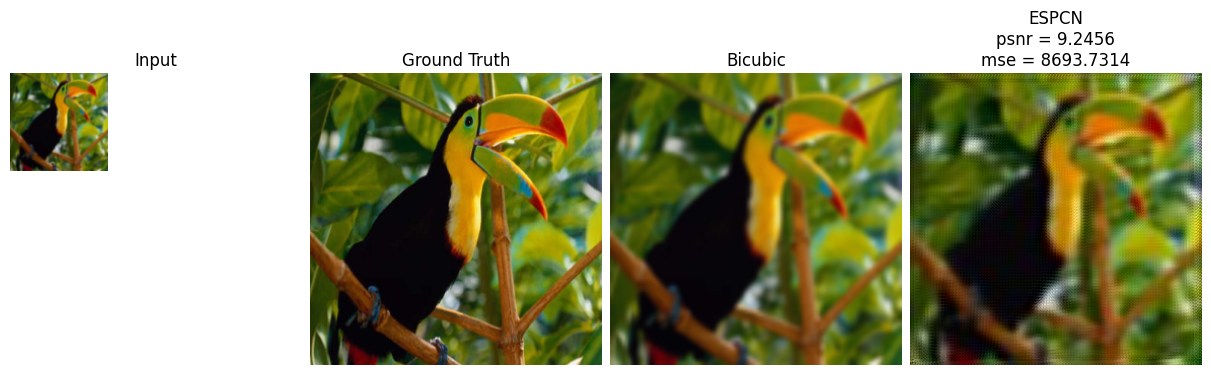

In [38]:
set5_path = "Images/Set5"
images = os.listdir(set5_path)

from torcheval.metrics.functional import peak_signal_noise_ratio, mean_squared_error

# import torchvision.transforms.functional

model = torch.load(
    "tmp/.model_parameters/model-epoch_010-upscale_factor_003.pth", weights_only=False
)

for img in images[:-3]:
    img = os.path.join(set5_path, img)

    x = load_img(img)

    crop_size_h, crop_size_v = list(
        map(lambda cs: calculate_valid_crop_size(cs, 3), x.size)
    )

    target = torchvision.transforms.functional.to_tensor(load_img(img))
    target = torchvision.transforms.functional.center_crop(
        target, (crop_size_h, crop_size_v)
    )

    img_original = PIL.Image.open(img).copy()
    img_in = downsample_image(img, out="tmp/my_downsampled_image.jpg")
    fp_in = "tmp/my_downsampled_image.jpg"

    input, cb, cr = image_to_input(fp_in)

    out = model(input)
    img_out = output_to_image(out, cb, cr)

    psnr = peak_signal_noise_ratio(
        target.view(crop_size_h, crop_size_v), out.view(crop_size_h, crop_size_v)
    ).item()
    mse = mean_squared_error(
        target.view(crop_size_h, crop_size_v), out.view(crop_size_h, crop_size_v)
    ).item()

    img_in_upscaled = img_in.resize(img_out.size, PIL.Image.BICUBIC)

    img_out.save("tmp/asd.jpg")


fig, axs = plt.subplots(
    1, 4, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True
)
ax_iter = iter(axs)

ax = next(ax_iter)
ax.imshow(img_in)
ax.set_title("Input")
ax = next(ax_iter)
ax.imshow(img_original)

ax.set_title("Ground Truth")

ax = next(ax_iter)
ax.imshow(img_in_upscaled)
ax.set_title("Bicubic")

ax = next(ax_iter)
ax.imshow(img_out)
ax.set_title(f"ESPCN\n{psnr = :.4f}\n{mse = :.4f}")

for ax in axs:
    ax.axis("off")  # remove the ticks

plt.show()

### Filters visualization

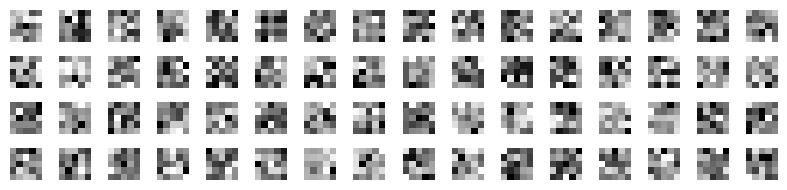

In [34]:
model: ESPCN = torch.load(
    "tmp/.model_parameters/model-epoch_010-upscale_factor_003.pth", weights_only=False
)

# first layer filter
filters = model.conv1.weight.detach()

grid_size = len(filters)

fig, axes = plt.subplots(4, 16, figsize=(8, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i][0].numpy(), cmap="gray")
    ax.axis("off")


plt.tight_layout()
plt.show()

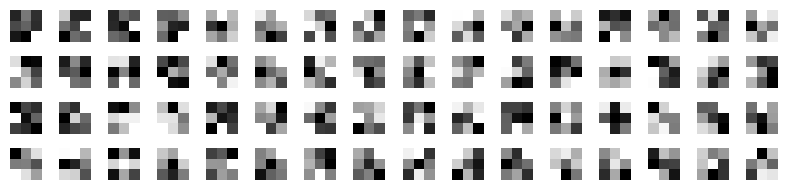

In [35]:
# second layer filter
filters = model.conv2.weight.detach()

grid_size = len(filters) 
fig, axes = plt.subplots(4, 16, figsize=(8, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i][0].numpy(), cmap='gray')  
    ax.axis('off') 


plt.tight_layout()
plt.show()

# for filter in model.conv1.weight.detach():    
#     filter = filter[0].numpy()
#     plt.imshow(filter, cmap='gray')
#     plt.axis('off')
